<a href="https://colab.research.google.com/github/mingd00/Face-Recognition/blob/main/Notebooks/EfficientNet(with_FER).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNet 모델을 활용한 FER 데이터 학습



### 0. 라이브러리 호출

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import cv2
import time

### 1. 모델 로드

**- 얼굴 인식 모델**

In [7]:
# 얼굴 인식 함수
def detect_face(frame):
    cascPath = '/content/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=6,
        minSize=(48, 48),  # 얼굴 크기
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    if len(detected_faces) > 0:
        return gray, detected_faces[0]  # 첫 번째 얼굴만 처리
    else:
        return gray, None  # 얼굴이 탐지되지 않으면 None 반환

In [8]:
# 얼굴 특징 추출 함수
def extract_face_features(gray, detected_face, offset_coefficients=(0.075, 0.05), shape_x=48, shape_y=48):
    if detected_face is None:
        return None  # 얼굴이 없으면 None 반환

    x, y, w, h = detected_face

    horizontal_offset = int(np.floor(offset_coefficients[0] * w))
    vertical_offset = int(np.floor(offset_coefficients[1] * h))

    # 추출할 얼굴 영역 설정
    extracted_face = gray[
        y + vertical_offset : y + h,
        x + horizontal_offset : x - horizontal_offset + w
    ]

    # 추출된 얼굴 이미지를 줌 조정 (설정된 크기로 스케일 변경)
    new_extracted_face = zoom(
        extracted_face,
        (shape_x / extracted_face.shape[0], shape_y / extracted_face.shape[1])  # 목표 크기로 조정
    )

    # 데이터를 float32 형식으로 변환
    new_extracted_face = new_extracted_face.astype(np.float32)

    # 이미지를 정규화 (최대값으로 나누어 0~1 사이 값으로 변환)
    new_extracted_face /= float(new_extracted_face.max())

    # 정규화된 얼굴 이미지를 반환
    return new_extracted_face

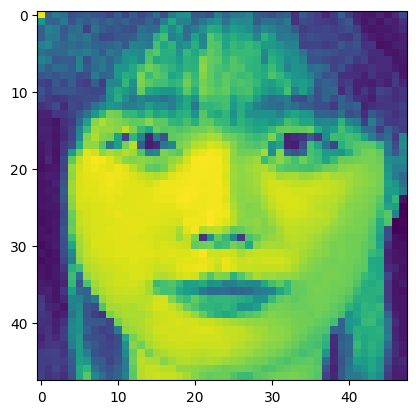

In [12]:
img = cv2.imread("img.jpg")
gray, detected_face = detect_face(img)

if detected_face is not None:
    extracted_face = extract_face_features(gray, detected_face)
    plt.imshow(extracted_face)
else:
    print("No face detected in the image.")

**- 표정 분류 모델**

- 모델 기본 구조 확인

In [ ]:
# 모델 로드 (ImageNet 가중치 사용)
model = EfficientNetB0(weights='imagenet', include_top=True)

# 모델 구조 출력
model.summary()

21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 5,330,571 (20.33 MB)

 Trainable params: 5,288,548 (20.17 MB)

 Non-trainable params: 42,023 (164.16 KB)

- 모델 수정: 사전 학습된 가중치는 고정하고 새로운 출력 레이어만 학습

In [ ]:
# 1. EfficientNetB0 로드 (사전 학습된 ImageNet 가중치 사용)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# 2. 모델 수정 (FER 데이터셋에 맞게 출력 레이어 조정)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # 공간 차원을 평균화하여 벡터로 변환
x = Dense(128, activation='relu')(x)  # 추가 Fully Connected Layer
predictions = Dense(7, activation='softmax')(x)  # FER 데이터셋의 7개 감정 클래스 출력

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 48, 48, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 48, 48, 3)      │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 48, 48, 3)      │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 49, 49, 3)      │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 24, 24, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 24, 24, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 24, 24, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 24, 24, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 24, 24, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 24, 24, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 4,172,419 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
# 3. 사전 학습된 가중치 잠금 (Feature Extraction)
for layer in base_model.layers:
    layer.trainable = False  # EfficientNet 가중치 고정

# 4. 컴파일
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 2. FER 데이터 로드 및 준비

In [ ]:
# FER 데이터셋 로드
data = pd.read_csv("fer2013.csv")

# 데이터 및 라벨 분리
pixels = data['pixels'].str.split(" ").tolist()  # 픽셀 데이터를 리스트로 변환
pixels = np.array(pixels, dtype='float32') / 255.0  # 정규화
pixels = pixels.reshape(-1, 48, 48, 1)  # 48x48 그레이스케일 이미지 형태로 변환
pixels = np.repeat(pixels, 3, axis=-1)  # 그레이스케일 이미지를 3채널로 확장 (EfficientNet 입력 요구사항)

labels = to_categorical(data['emotion'], num_classes=7)

# 학습/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(pixels, labels, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((28709, 48, 48, 3), (7178, 48, 48, 3), (28709, 7), (7178, 7))

### 3. 표정 분류 모델 학습

In [ ]:
# 데이터 증강
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=32)

In [ ]:
# 첫 번째 학습: Feature Extraction (사전 학습된 가중치 고정)
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_val) // 32
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


897/897 ━━━━━━━━━━━━━━━━━━━━ 71s 55ms/step - accuracy: 0.2268 - loss: 1.8336 - val_accuracy: 0.2461 - val_loss: 1.8103
Epoch 2/10
  1/897 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4375 - loss: 1.6514

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4375 - loss: 1.6514 - val_accuracy: 0.1000 - val_loss: 1.8378
Epoch 3/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.2447 - loss: 1.8180 - val_accuracy: 0.2457 - val_loss: 1.8110
Epoch 4/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - accuracy: 0.4062 - loss: 1.6984 - val_accuracy: 0.4000 - val_loss: 1.6624
Epoch 5/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.2463 - loss: 1.8171 - val_accuracy: 0.2458 - val_loss: 1.8130
Epoch 6/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 24us/step - accuracy: 0.1562 - loss: 1.8644 - val_accuracy: 0.3000 - val_loss: 1.6914
Epoch 7/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.2532 - loss: 1.8151 - val_accuracy: 0.2461 - val_loss: 1.8107
Epoch 8/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 25us/step - accuracy: 0.2812 - loss: 1.8570 - val_accuracy: 0.1000 - val_loss: 1.9019
Epoch 9/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.2537 - loss: 1.8121 - val_accuracy: 0.

In [ ]:
# 두 번째 학습: Fine-Tuning (가중치 조정 가능하게 변경)
for layer in base_model.layers:
    layer.trainable = True  # EfficientNet 가중치 조정 가능하게 변경

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=2,
                    steps_per_epoch=len(X_train) // 32,
                    validation_steps=len(X_val) // 32
                    )

Epoch 1/2
897/897 ━━━━━━━━━━━━━━━━━━━━ 131s 79ms/step - accuracy: 0.4593 - loss: 1.3954 - val_accuracy: 0.1819 - val_loss: 1.9967
Epoch 2/2
  1/897 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.5000 - loss: 1.2660

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5000 - loss: 1.2660 - val_accuracy: 0.1000 - val_loss: 2.1222


### 4. 모델 평가

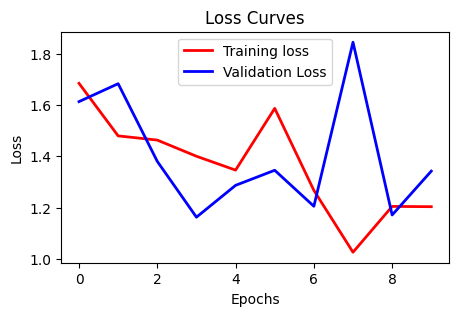

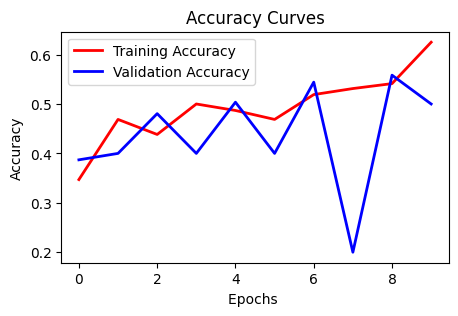

In [ ]:
# 손실 함수
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')

# 정확도
plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs ')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

plt.show()

### 5. 모델 저장 및 호출

In [ ]:
# 모델 저장(구조, 가중치 별도 저장)
path = '/content/'
json_string = model.to_json()
model.save_weights(path + 'model.weights.h5')
open(path + 'model.json', 'w').write(json_string)

222052

In [ ]:
# 모델 저장
model.save('model.keras')

In [11]:
# 저장한 모델 불러오기
new_model = load_model('model.keras')
print("Loaded Complete")

Loaded Complete


### 5. 예측

In [13]:
# 감정 라벨
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

- 사진 예측

In [14]:
img = cv2.imread("img.jpg")
gray, detected_face = detect_face(img)

if detected_face is not None:
    extracted_face = extract_face_features(gray, detected_face)
    if extracted_face is not None:
        # 예시: 모델에 입력하기 전에 이미지를 3채널로 확장 (EfficientNet 입력 요구 사항)
        extracted_face = np.repeat(extracted_face, 3, axis=-1)  # 1채널을 3채널로 변환
        extracted_face = np.reshape(extracted_face, (1, 48, 48, 3))  # 모델 입력 형태로 변환

        # 예측 (모델은 이미 로드되어 있다고 가정)
        res = new_model.predict(extracted_face)
        result_num = np.argmax(res)
        print(f"표정 예측: {emotion_labels[result_num]}")
        for i, prob in enumerate(res[0]):
            print(f"Class {i} ({emotion_labels[i]}): {prob * 100:.2f}%")
    else:
        print("얼굴 추출에 실패했습니다.")
else:
    print("얼굴을 찾을 수 없습니다.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
표정 예측: Neutral
Class 0 (Angry): 14.95%
Class 1 (Disgust): 1.54%
Class 2 (Fear): 9.45%
Class 3 (Happy): 9.30%
Class 4 (Sad): 22.41%
Class 5 (Surprise): 2.88%
Class 6 (Neutral): 39.47%


- 영상 예측(0.5초에 한번씩 캡쳐해서 이미지로 예측)

In [22]:
# 영상 파일 경로
video_path = 'video.mp4'  # 영상 파일 경로 지정

# 영상 파일 열기
video_capture = cv2.VideoCapture(video_path)

# 영상의 FPS 확인
fps = video_capture.get(cv2.CAP_PROP_FPS)  # 초당 프레임 수
frame_interval = int(fps / 2)  # 0.5초 기준 프레임 간격 계산

# 현재 시간
frame_count = 0  # 프레임을 카운트하는 변수

while True:
    # 영상에서 프레임 읽기
    ret, frame = video_capture.read()

    # 프레임이 제대로 읽어졌는지 확인
    if not ret:
        print("영상에서 프레임을 읽을 수 없습니다.")
        break

    # 0.5초마다 프레임을 처리
    if frame_count % frame_interval == 0:
        # 얼굴 감지 및 특징 추출
        gray, detected_face = detect_face(frame)

        # 초 계산
        current_time_sec = frame_count / fps

        if detected_face is not None:
            # 얼굴 특징 추출
            extracted_face = extract_face_features(gray, detected_face)
            if extracted_face is not None:
                # 1채널 이미지를 3채널로 확장
                extracted_face = np.repeat(extracted_face, 3, axis=-1)
                extracted_face = np.reshape(extracted_face, (1, 48, 48, 3))  # 모델 입력 형태로 변환

                # 예측 (모델은 이미 로드되어 있다고 가정)
                res = new_model.predict(extracted_face)
                result_num = np.argmax(res)
                print(f"[{current_time_sec:.2f}초] 표정 예측: {emotion_labels[result_num]}")

                # 각 클래스에 대한 확률을 출력
                for i, prob in enumerate(res[0]):
                    print(f"Class {i} ({emotion_labels[i]}): {prob * 100:.2f}%")
            else:
                print("얼굴 추출에 실패했습니다.")
        else:
            print("얼굴을 찾을 수 없습니다.")

    # 프레임 카운트 증가
    frame_count += 1

# 모든 작업 완료 후 캡처 리소스 해제
video_capture.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[0.00초] 표정 예측: Sad
Class 0 (Angry): 12.15%
Class 1 (Disgust): 1.27%
Class 2 (Fear): 11.54%
Class 3 (Happy): 12.81%
Class 4 (Sad): 30.06%
Class 5 (Surprise): 3.30%
Class 6 (Neutral): 28.86%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.50초] 표정 예측: Sad
Class 0 (Angry): 16.58%
Class 1 (Disgust): 1.17%
Class 2 (Fear): 11.97%
Class 3 (Happy): 13.91%
Class 4 (Sad): 28.92%
Class 5 (Surprise): 2.81%
Class 6 (Neutral): 24.65%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[1.00초] 표정 예측: Neutral
Class 0 (Angry): 11.70%
Class 1 (Disgust): 1.33%
Class 2 (Fear): 11.24%
Class 3 (Happy): 10.50%
Class 4 (Sad): 25.28%
Class 5 (Surprise): 3.51%
Class 6 (Neutral): 36.44%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[1.50초] 표정 예측: Neutral
Class 0 (Angry): 12.75%
Class 1 (Disgust): 2.01%
Class 2 (Fear): 10.29%
Class 3 (Happy): 11.70%
Class 4 (Sad): 20.91%
Class 5 (Surprise): 3.45%
Class 6 (Neutral): 38.89%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[2.00초] 표정 예측: Neutral
Class 0 (Angry): 12.59%